## Introduction

Including outliers in data driven models could be risky. The existence of an extreme single misleading value has the potential to change the conclusion implied by the model. It is therefore important to manage that kind of risk.

This notebook explains six of the most popular outlier detection methods:
* Tukey's IQR method
* Standard deviation method
* Z-score method
* Modified Z-score method
* Isolation Forest
* DBSCAN

Some of these methods are sensitive to extreme values like the SD method, and others are resistant to extreme values, like Tukey's method.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_raw = pd.read_csv('/kaggle/input/fraud-detection/creditcard.csv')
df = df_raw.drop(columns=['Time'])

In [3]:
features = df.columns[:-1].tolist()
features, len(features)

(['V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6',
  'V7',
  'V8',
  'V9',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V15',
  'V16',
  'V17',
  'V18',
  'V19',
  'V20',
  'V21',
  'V22',
  'V23',
  'V24',
  'V25',
  'V26',
  'V27',
  'V28',
  'Amount'],
 29)

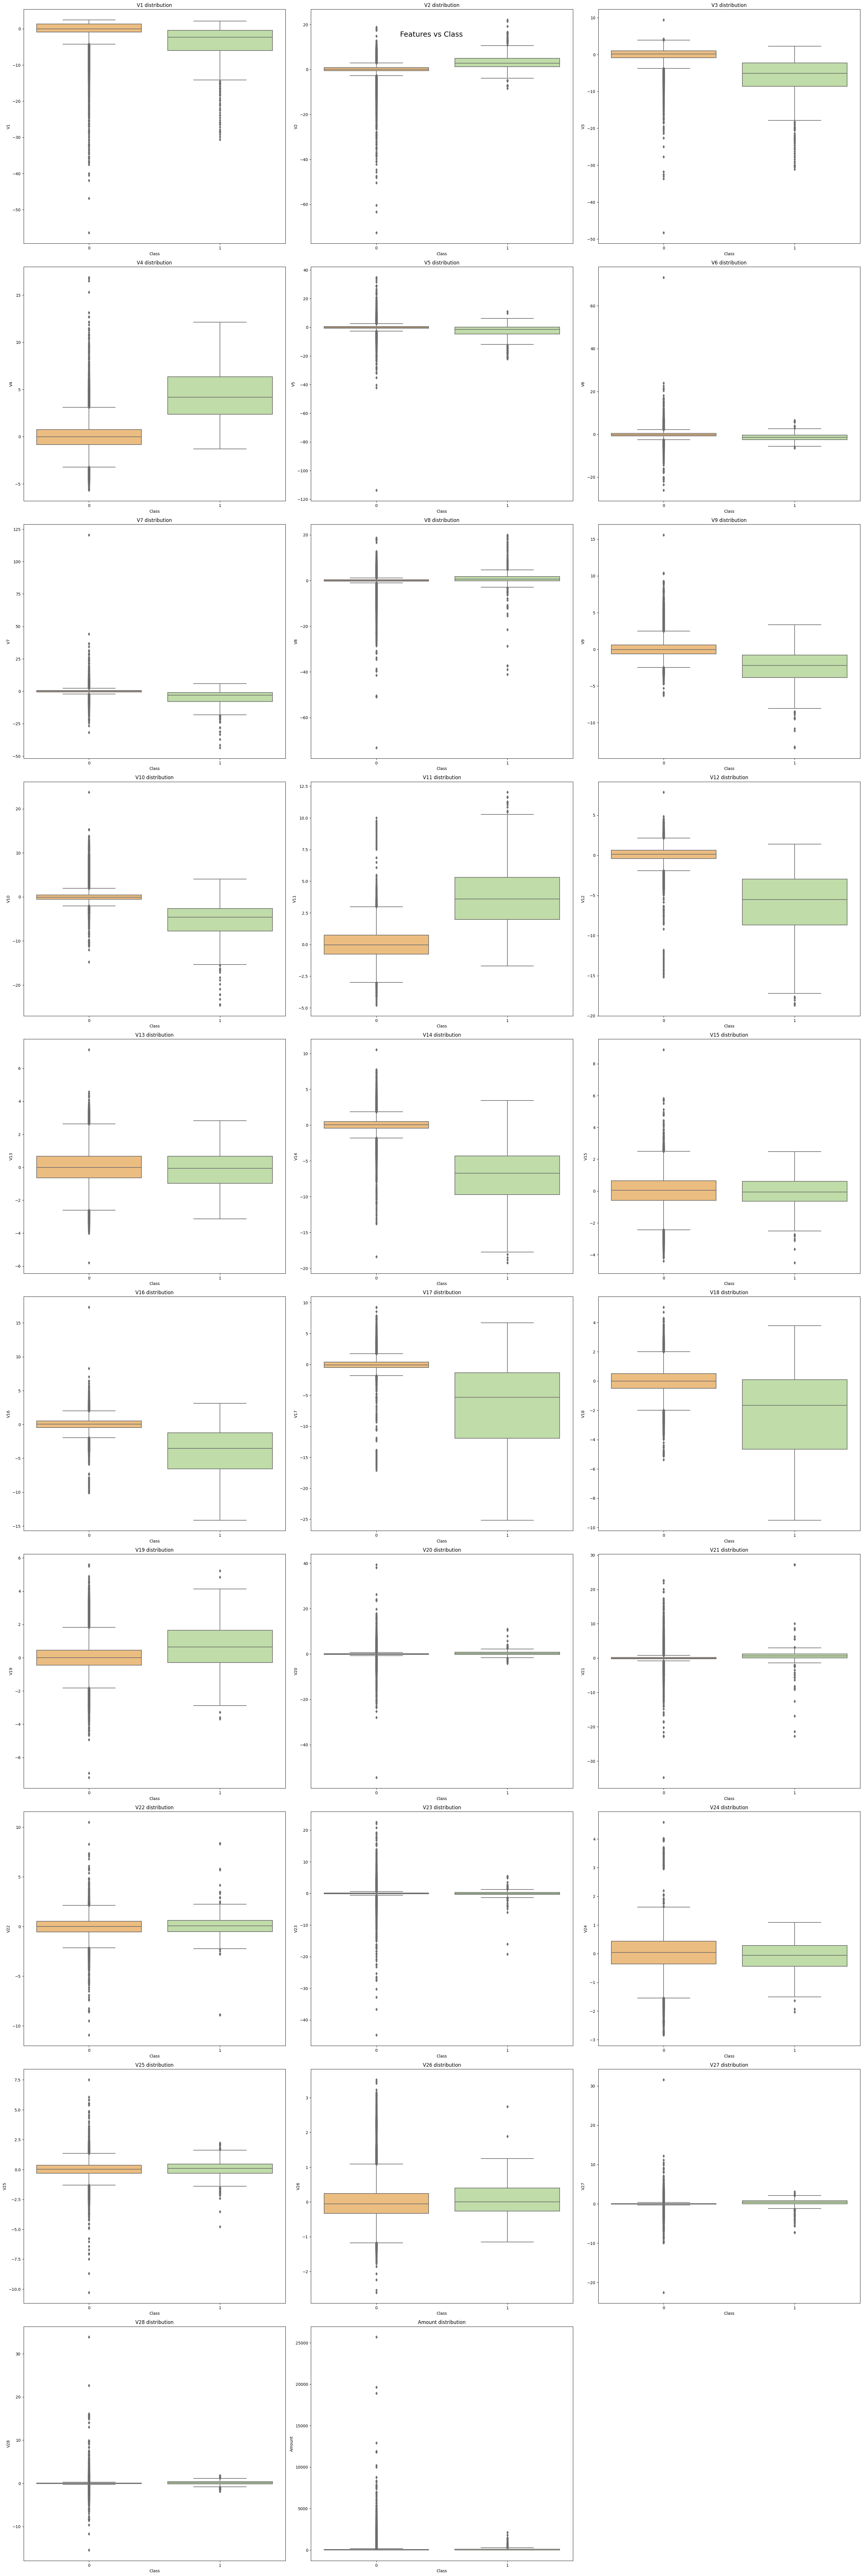

In [4]:
nrows, ncols = 10, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 90))

fig.suptitle('Features vs Class\n', size=18)
idx = 0

for row in range(nrows):
    for col in range(ncols):
        if idx < len(features):  
            sns.boxplot(ax=axes[row, col], data=df, x='Class', y=features[idx], palette='Spectral')
            axes[row, col].set_title(f'{features[idx]} distribution')
        else:
            axes[row, col].axis('off')  
        idx += 1

plt.tight_layout()  
plt.show()

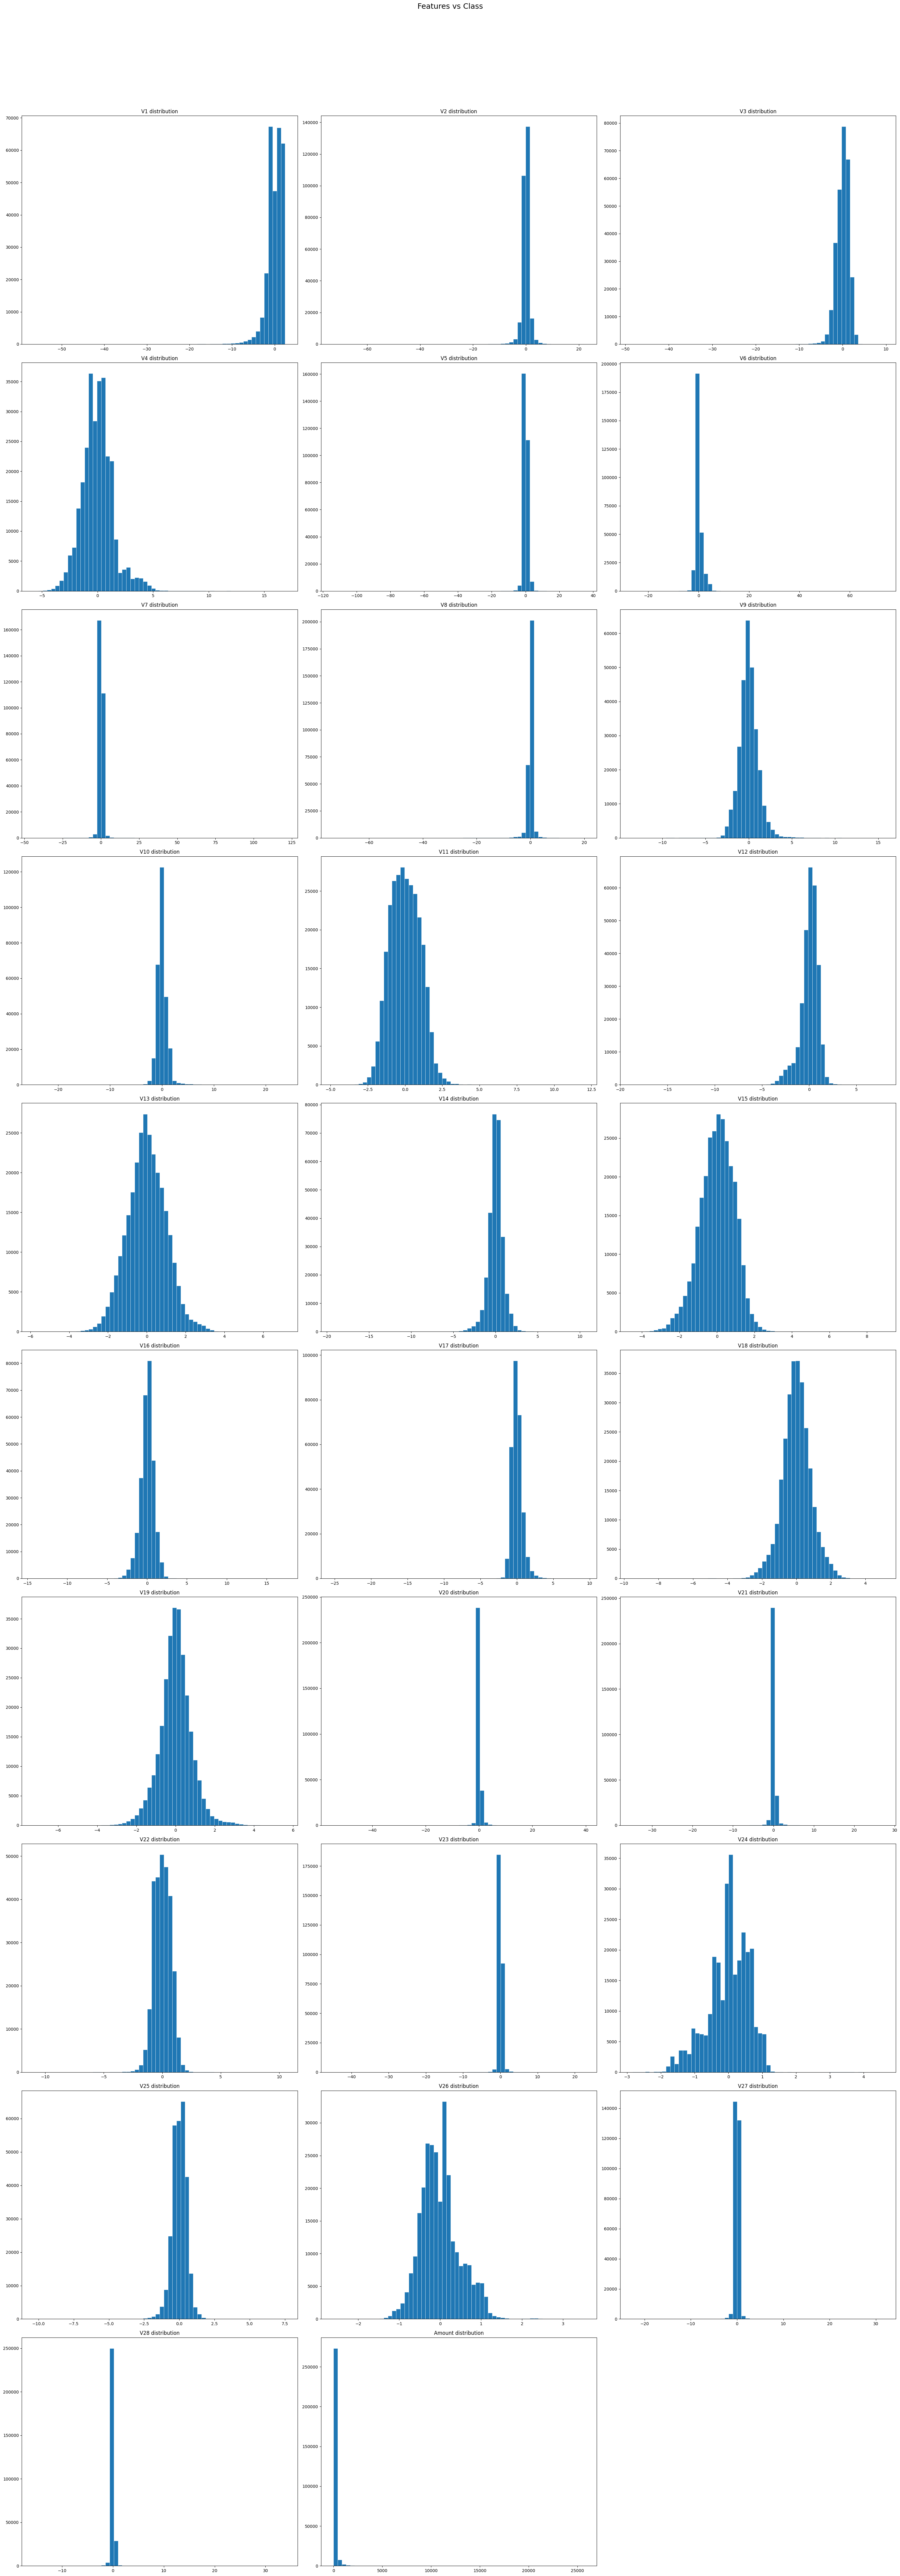

In [5]:
nrows, ncols = 10, 3  
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 90))
fig.suptitle('Features vs Class\n', size=18)
idx = 0

for row in range(nrows):
    for col in range(ncols):
        if idx < len(features):  
            axes[row, col].hist(df[features[idx]], bins=60, linewidth=0.5, edgecolor="white")
            axes[row, col].set_title(f'{features[idx]} distribution')
        else:
            axes[row, col].axis('off') 
        idx += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

## 1. Tukey's IQR Method
1. Used to detect outliers in **skewed** or **non bell-shaped data** since it makes not assumptions.
2. Not appropriate for a small sample size.
3. The general rule is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed.

Inter Quartile Range (IQR) is one of the most extensively used procedures for outlier detection and removal.

Procedure:
1. Find the first quartile Q1
2. Find the third quartile Q3
3. Calculate the IQR, IQR = Q3 - Q1
4. Define the normal data range with lower limit as Q1 - 1.5 IQR and upper limit as QQ3 + 1.5 IQR

Any data point outside this range is considered as outlier and should be removed for further analysis.

In [6]:
import numpy as np
from collections import Counter 

def IQR_method(df, n, features):
    """
    Identifies outliers in a DataFrame using Tukey's IQR method.
    
    Args:
        df (pandas.DataFrame): The DataFframe containing data to be analyzed.
        n (int): The threshold number of features. An index is considered a multiple outlier if it is an outlier in 
                 more than 'n' features.
        features (list of str): A list of column names (features) in the DataFrame to check for outliers.
        
        Returns:
            (list): A list of indices (row) that are identified as outliers in more than 'n' features.
    """
    outlier_list = []
    
    for feature in features:
        Q1 = np.percentile(df[feature], 25)
        Q3 = np.percentile(df[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outliers = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)]
        outlier_list.extend(outliers.index)
    
    outlier_counts = Counter(outlier_list)
    multiple_outliers = [index for index, count in outlier_counts.items() if count > n]
    
    print(f'Total number of outliers: {len(multiple_outliers)}')
    
    return multiple_outliers

In [7]:
# Detecting outliers
outliers_IQR = IQR_method(df, 1, features)

# Dropping outliers
df_out = df.drop(outliers_IQR, axis=0).reset_index(drop=True)
df_out

Total number of outliers: 81430


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
3,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
4,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203372,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0
203373,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69,0
203374,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
203375,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


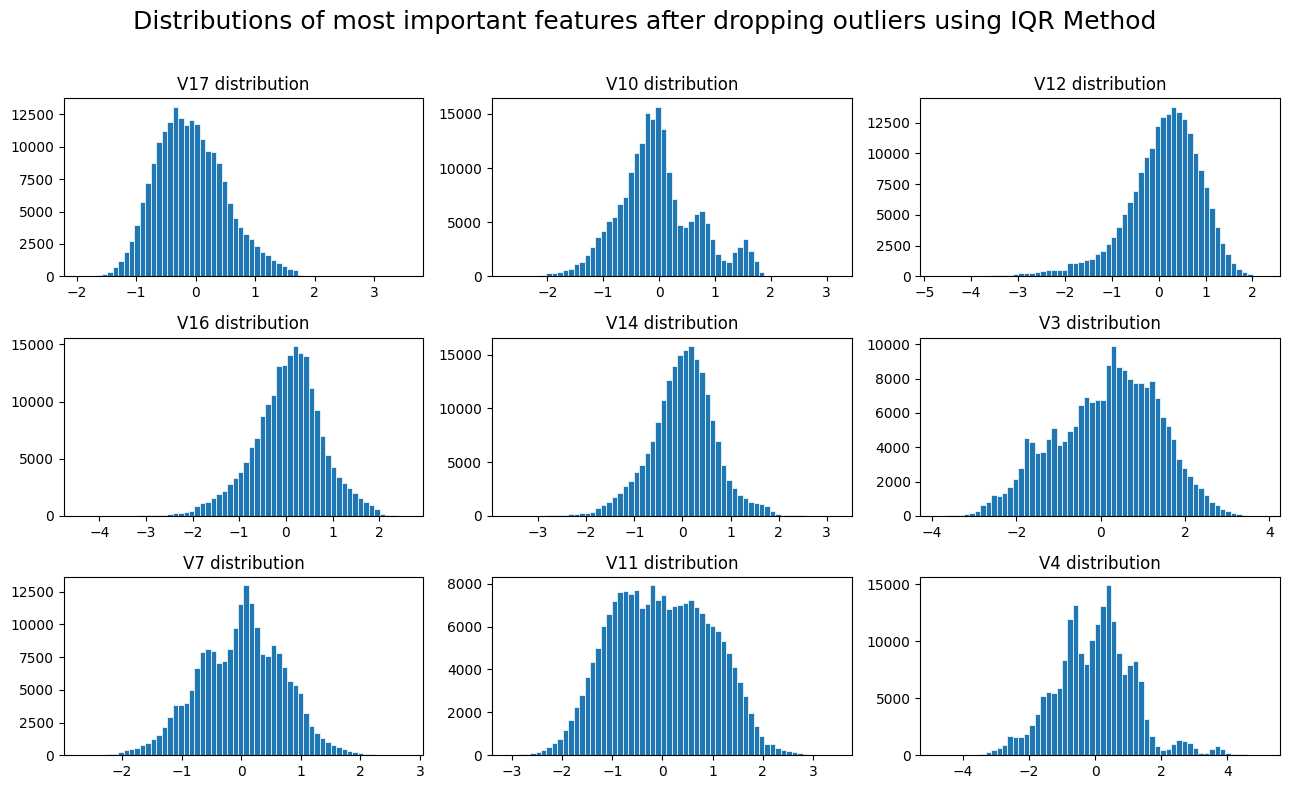

In [8]:
# Checking distributions of most important features after dropping outliers
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using IQR Method\n', size = 18)

axes[0,0].hist(df_out['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

## 2. Standard Deviation Method

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

Standard deviation shows how much the individual data points are spread out from the mean. If a data distribution is normal then:
* 68% of the data values lie within one standard deviation of the mean
* 95% are within two standard deviations
* 99.7% lie within three standard deviations

Depending on the set application either at 2 times stdev or 3 times stdev, we can detect and remove outliers from the dataset.

This method can fail to detect outliers because the outliers increase the standard deviation. The more extreme the outlier, the more the standard deviation is affected.
    


In [9]:
from collections import Counter

def std_method(df, n, features):
    """
    Detects outliers in a given DataFrame using the standard deviation method,
    and returns indices of rows with multiple outliers.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the data to be analyzed.
        
        n (int): The minimum number of frequencies for which an outlier must occur
                 for a row to be considered a 'multiple outlier' and included in the output.
                 
        features (list): A list of column names (features) in the DataFrame for which to check for outliers.
        
    Returns:
        multiple_outliers (list): A list of row indices that have more than 'n' outliers across the given features.
        
    Notes:
        - This function assumes that the features in the DataFrame are numerical.
        - The outliers are identified by using a 3-sigma (standard deviation) rule.
        - Rows with multiple outliers across different feature will be flagged
          if the number of outliers exceeds the threshold 'n'.
    """
    outlier_indices = []
    
    for feature in features:
        mean = df[feature].mean()
        std = df[feature].std()
        
        cut_off = std * 3
        
        outlier_list_column = df[(df[feature] < mean - cut_off) | (df[feature] > mean + cut_off)].index
        outlier_indices.extend(outlier_list_column)
        
    # Count the occurrences of each index
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    # Count total outliers across all features
    total_outliers = len([i for i, count in outlier_indices.items() if count > 0])
    
    print(f'Total number of outliers is: {total_outliers}')
    
    return multiple_outliers

outliers_stdev = std_method(df, 1, features)
df_out_2 = df.drop(outliers_stdev, axis=0).reset_index(drop=True)

Total number of outliers is: 37816


The lower bound value is: -3.0621390831346735
The upper bound value is: 3.062139083134677


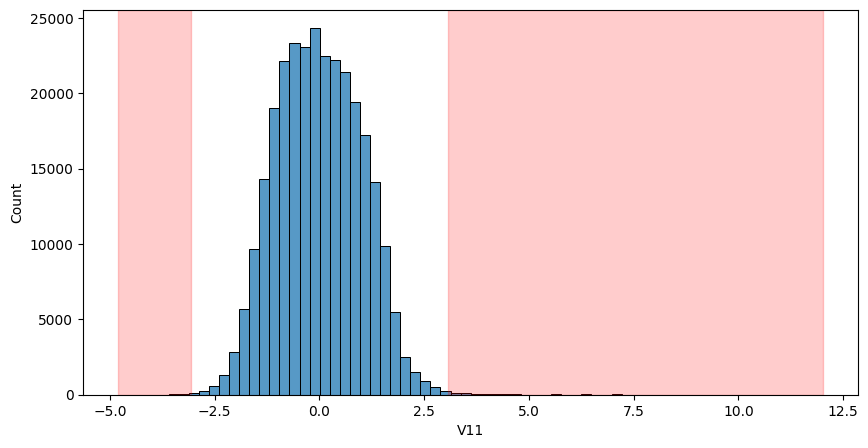

In [10]:
data_mean, data_std = df['V11'].mean(), df['V11'].std()
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

print('The lower bound value is:', data_mean - cut_off)
print('The upper bound value is:', data_mean + cut_off)

plt.figure(figsize = (10,5))
sns.histplot(x = 'V11', data=df, bins=70)
plt.axvspan(xmin = lower,xmax= df.V11.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df.V11.max(),alpha=0.2, color='red')

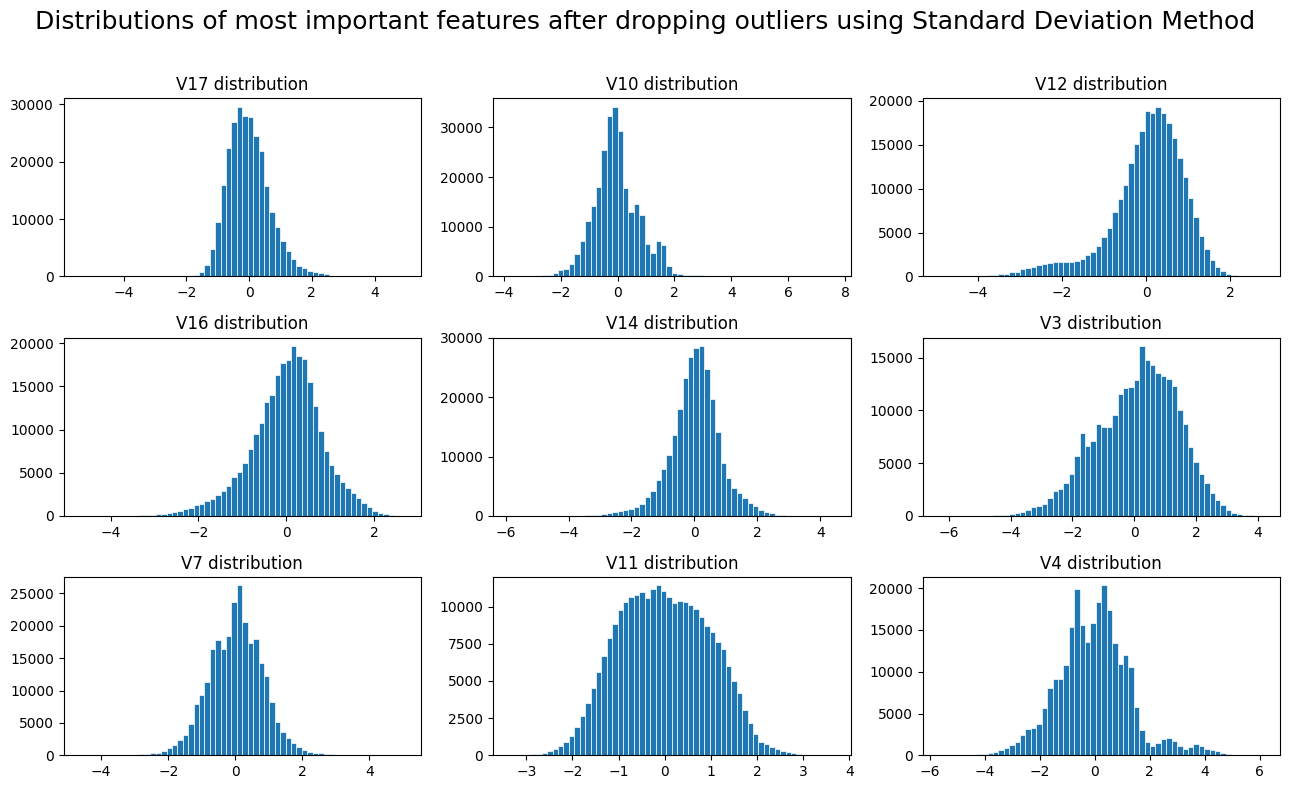

In [12]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using Standard Deviation Method\n', size = 18)


axes[0,0].hist(df_out_2['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out_2['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out_2['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out_2['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out_2['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out_2['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out_2['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out_2['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out_2['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout();

## 3. Z-score method

While calculating the Z-score we rescale and center the data and look for data points which are too far from zero. Z-score is used to convert the data into another dataset with mean = 0.

Z -score describes the position of a raw score in terms of its distance from the mean, when measure in standard deviation units.

This technique assumes a **Gaussian distribution** of the data. The outliers are the data points that are in the tails of the distribution.

In [13]:
def z_score_method(df, n, features):
    """
    """
    outlier_indices = []
    total_outliers = 0
    
    for feature in features:
        mean = df[feature].mean()
        std = df[feature].std()
        threshold = 3
        z_score = abs((df[feature] - mean) / std)
        
        outlier_list_column = df[z_score > threshold].index
        outlier_indices.extend(outlier_list_column)
        
        total_outliers += df[z_score > threshold].shape[0]
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    print(f'Total number of outliers across all features: {total_outliers}')
    
    return multiple_outliers

outliers_zscore = z_score_method(df, 1, features)
df_out_3 = df.drop(outliers_zscore, axis=0).reset_index(drop=True)

Total number of outliers across all features: 83598


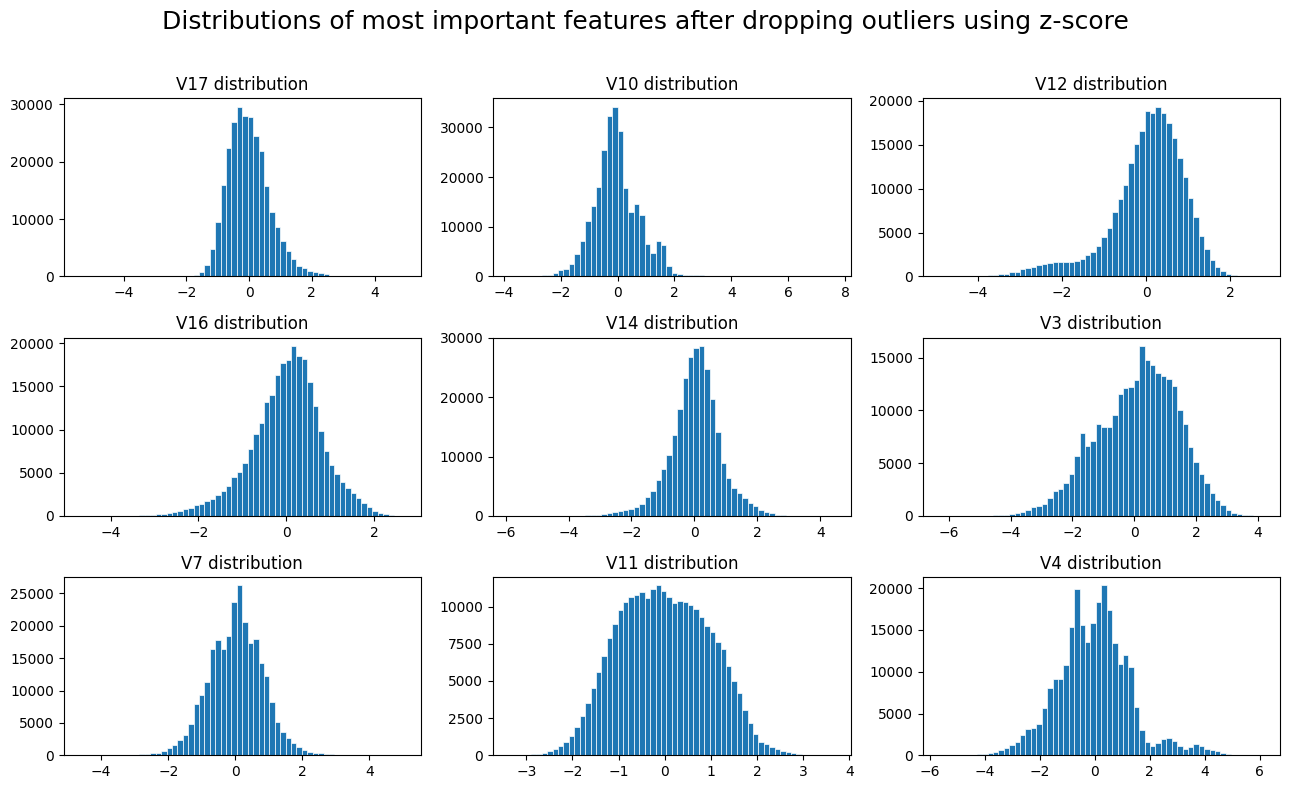

In [15]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using z-score\n', size = 18)

axes[0,0].hist(df_out_3['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out_3['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out_3['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out_3['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out_3['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out_3['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out_3['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out_3['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out_3['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout();